## CMA-ES for CartPole Torch (assignment version)
### Christian Igel, 2024

If you have suggestions for improvement, [let me know](mailto:igel@diku.dk).

You may need the following packages:

``pip install gymnasium[classic-control]``

``python -m pip install cma``

In [2]:
import gymnasium as gym  # Defines RL environments

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)  # Set size of visualization
from IPython.display import clear_output  # For inline visualization

import torch
import torch.nn as nn
import torch.nn.functional as F

import cma

# Define task
env = gym.make('CartPole-v1')
state_space_dimension = env.observation_space.shape[0]
action_space_dimension = 1  # env.action_space.n - 1

In [3]:
print(env.observation_space, '\n', env.action_space)

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32) 
 Discrete(2)


In [ ]:
import sympy as sp

# Define the variable and the likelihood function
sigma2 = sp.symbols('sigma2')
sigma = sp.symbols('sigma')
a = sp.symbols('a')

likelihood = 1/sp.sqrt(2*sp.pi*sigma2) * sp.exp(-a**2/(2*sigma2))

log_likelihood = -1/2 * sp.log(2 * sp.pi * sigma2) - a**2 / (2 * sigma2)


derivative = sp.diff(likelihood, sigma2)

log_derivative = sp.diff(log_likelihood, sigma2)

print(derivative, '\n', log_derivative)


solution = sp.solve(derivative, sigma2)

log_solution = sp.solve(log_derivative, sigma2)


print(solution,log_solution)


Define the policy network:

In [4]:
# Model definition
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size=5, output_size=1, use_bias=True):
        super(PolicyNet, self).__init__()
        self.hidden = nn.Linear(4, 5, bias=use_bias)  # 4 input features -> 5 hidden neurons
        self.output = nn.Linear(5, 1, bias=use_bias)  # 5 hidden neurons -> 1 output neuron

    def forward(self, x):
        """ Forward pass of the network. """
        x = torch.tanh(self.hidden(x))  # Apply tanh activation to hidden layer
        x = self.output(x)  # Linear activation at output
        return x

In [5]:
input_size = 1
model = PolicyNet(input_size=input_size, use_bias=True)

Compute number of parameters:

In [6]:
d = sum(
	param.numel() for param in model.parameters()
)
print("Number of parameters:", d)

Number of parameters: 31


Helper function for visualization:

In [7]:
def visualize_policy(policy_net):
    env_render = gym.make('CartPole-v1', render_mode='rgb_array')
    state = env_render.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
    steps = 0
    print(state_tensor)
    while True:
        out = policy_net(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env_render.step(a)  # Simulate pole
        steps+=1
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        clear_output(wait=True)
        plt.imshow(env_render.render())
        plt.show()
        print("step:", steps)
        if(terminated or truncated): 
            break
    env_render.close()
    return

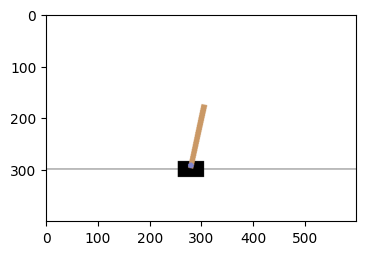

step: 15


In [8]:
visualize_policy(PolicyNet(4))

Now we define the objective/reward function. 
When the task is solved the functions returns -1000.
One successful trial is sufficient.

In [9]:
def fitness_cart_pole(x, nn, env):
    '''
    Returns negative accumulated reward for single pole, fully environment.

    Parameters:
        x: Parameter vector encoding the weights.
        nn: Parameterized model.
        env: Environment ('CartPole-v?').
    '''
    torch.nn.utils.vector_to_parameters(torch.Tensor(x), nn.parameters())  # Set the policy parameters
    
    state = env.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
          
    R = 0  # Accumulated reward
    while True:
        out = nn(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env.step(a)  # Simulate pole
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        R += reward  # Accumulate 
        if truncated:
            return -1000  # Episode ended, final goal reached, we consider minimization
        if terminated:
            return -R  # Episode ended, we consider minimization
    return -R  # Never reached  

Do the learning:

In [10]:
# Generate initial search point and initial hidden RNN states
initial_weights = np.random.normal(0, 0.01, d)  # Random parameters for initial policy, d denotes the number of weights
initial_sigma = .01 # Initial global step-size sigma

# Do the optimization
res = cma.fmin(fitness_cart_pole,  # Objective function
               initial_weights,  # Initial search point
               initial_sigma,  # Initial global step-size sigma
               args=([PolicyNet(4), env]),  # Arguments passed to the fitness function
               options={'ftarget': -999.9, 'tolflatfitness':1000, 'eval_final_mean':False})
env.close()

# Set the policy parameters to the final solution
torch.nn.utils.vector_to_parameters(torch.Tensor(res[0]), model.parameters())  

print("best solution found after", res[2], "evaluations")

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 31 (seed=605120, Wed Feb 26 19:57:29 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.000000000000000e+01 1.0e+00 9.32e-03  9e-03  9e-03 0:00.0
    2     28 -1.100000000000000e+01 1.1e+00 8.83e-03  9e-03  9e-03 0:00.0
    3     42 -1.000000000000000e+01 1.1e+00 8.61e-03  8e-03  9e-03 0:00.1
  100   1400 -1.100000000000000e+01 2.1e+00 1.10e-02  1e-02  1e-02 0:01.5
  200   2800 -1.000000000000000e+01 2.5e+00 1.23e-02  1e-02  1e-02 0:02.9
  300   4200 -1.100000000000000e+01 3.2e+00 1.60e-02  1e-02  2e-02 0:04.3
  400   5600 -1.100000000000000e+01 3.6e+00 7.23e-03  6e-03  9e-03 0:05.7
  500   7000 -1.000000000000000e+01 4.0e+00 1.34e-02  1e-02  2e-02 0:07.0
  600   8400 -1.000000000000000e+01 4.6e+00 8.82e-03  7e-03  1e-02 0:08.6
  700   9800 -1.000000000000000e+01 5.5e+00 7.09e-03  5e-03  9e-03 0:10.1
  800  11200 -1.000000000000000e+01 6.6e+00 1.06e-02  7e-03  1e-02 0:11.6
  900  12600 -1.000000

In [11]:
# Generate initial search point and initial hidden RNN states
initial_weights = np.random.normal(0, 0.01, d)  # Random parameters for initial policy, d denotes the number of weights
initial_sigma = .01 # Initial global step-size sigma

# Do the optimization
res = cma.fmin(fitness_cart_pole,  # Objective function
               initial_weights,  # Initial search point
               initial_sigma,  # Initial global step-size sigma
               args=([PolicyNet(4, use_bias=False), env]),  # Arguments passed to the fitness function
               options={'ftarget': -999.9, 'tolflatfitness':1000, 'eval_final_mean':False})
env.close()

# Set the policy parameters to the final solution
torch.nn.utils.vector_to_parameters(torch.Tensor(res[0]), model.parameters())  

print("best solution found after", res[2], "evaluations")

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 31 (seed=745287, Wed Feb 26 19:57:49 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.090000000000000e+02 1.0e+00 9.36e-03  9e-03  9e-03 0:00.0
    2     28 -8.600000000000000e+01 1.1e+00 9.17e-03  9e-03  9e-03 0:00.1
    3     42 -8.800000000000000e+01 1.1e+00 9.01e-03  9e-03  9e-03 0:00.1
    8    112 -1.000000000000000e+03 1.2e+00 8.67e-03  8e-03  9e-03 0:00.9
termination on ftarget=-999.9 (Wed Feb 26 19:57:50 2025)
final/bestever f-value = -1.000000e+03 -1.000000e+03 after 112/112 evaluations
incumbent solution: [-0.0120553   0.00089924  0.00352232  0.04225083  0.01895467  0.00560596
  0.00147084 -0.01175298 ...]
std deviations: [0.00849091 0.00862438 0.0086129  0.0088912  0.00854775 0.00854262
 0.00857644 0.00877245 ...]
best solution found after 112 evaluations


In [ ]:
import cma
import torch
import numpy as np
#import gym

# Assuming PolicyNet, model, and fitness_cart_pole are defined elsewhere

def run_experiment(use_bias, num_trials=10):
    evaluations_list = []
    balancing_times = []

    for trial in range(num_trials):
        env = gym.make('CartPole-v1')  # Or your specific CartPole environment
        d = sum(param.numel() for param in model.parameters())
        initial_weights = np.random.normal(0, 0.01, d)
        initial_sigma = 0.01

        if use_bias:
            policy_net = PolicyNet(4)
        else:
            policy_net = PolicyNet(4, use_bias=False)

        res = cma.fmin(fitness_cart_pole, initial_weights, initial_sigma,
                       args=([policy_net, env]),
                       options={'ftarget': -999.9, 'tolflatfitness': 1000, 'eval_final_mean': False})

        evaluations_list.append(res[2])  # Store the number of evaluations

        # Load the trained weights into the policy network
        torch.nn.utils.vector_to_parameters(torch.Tensor(res[0]), policy_net.parameters())

        # Evaluate the trained network from random starting positions
        #total_balancing_time = 0
        #for _ in range(5):  # Run a few evaluation episodes
        #    obs = env.reset()
        #    done = False
        #    balancing_time = 0
        #    while not done:
        #        # Extract the observation array from the tuple
        #        observation_array = obs[0]
        #        
        #        action = policy_net(torch.FloatTensor(observation_array)).argmax().item()
        #        
        #        # Update obs with the new tuple from env.step()
        #        obs = env.step(action)
                
        #        balancing_time += 1
        #    total_balancing_time += balancing_time
        #balancing_times.append(total_balancing_time / 5)  # Average balancing time

        env.close()

        # Print update after each trial
        print(f"Trial {trial + 1}/{num_trials} (Bias: {use_bias}) completed.")

    return evaluations_list, balancing_times

# Run experiments
evaluations_with_bias, balancing_times_with_bias = run_experiment(use_bias=True)
evaluations_without_bias, balancing_times_without_bias = run_experiment(use_bias=False)

# Analyze the results
print("\nWith Bias:")
print("Average Evaluations:", np.mean(evaluations_with_bias))
print("Average Balancing Time:", np.mean(balancing_times_with_bias))

print("\nWithout Bias:")
print("Average Evaluations:", np.mean(evaluations_without_bias))
print("Average Balancing Time:", np.mean(balancing_times_without_bias))

In [16]:
# Assuming 'model' is your PyTorch model and PolicyNet is defined

class PolicyNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=2, use_bias=True):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size, bias=use_bias)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size, bias=use_bias)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

def fitness_cart_pole(weights, policy_net, env):
    torch.nn.utils.vector_to_parameters(torch.Tensor(weights), policy_net.parameters())
    obs = env.reset()[0]
    done = False
    steps = 0
    while not done:
        action = policy_net(torch.FloatTensor(obs)).argmax().item()
        obs, _, done, _, _ = env.step(action)
        steps += 1
        if steps >= 500:
            return 500
    return steps

def run_experiment(use_bias, num_trials=10):
    evaluations_list = []
    balancing_times = []

    for trial in range(num_trials):
        env = gym.make('CartPole-v1')
        d = sum(param.numel() for param in model.parameters())
        initial_weights = np.random.normal(0, 0.01, d)
        initial_sigma = 0.1 # Increased sigma for faster convergence

        if use_bias:
            policy_net = PolicyNet(4)
        else:
            policy_net = PolicyNet(4, use_bias=False)

        res = cma.fmin(fitness_cart_pole, initial_weights, initial_sigma,
                       args=([policy_net, env]),
                       options={'ftarget': 500, 'tolflatfitness': 1000, 'eval_final_mean': False, 'maxiter': 5000})

        evaluations_list.append(res[2])

        torch.nn.utils.vector_to_parameters(torch.Tensor(res[0]), model.parameters())

        total_balancing_time = 0
        for _ in range(5):
            obs = env.reset()[0]
            done = False
            balancing_time = 0
            while not done:
                action = policy_net(torch.FloatTensor(obs)).argmax().item()
                obs, _, done, _, _ = env.step(action)
                balancing_time += 1
            total_balancing_time += balancing_time
        balancing_times.append(total_balancing_time / 5)

        env.close()
        print(f"Trial {trial + 1}/{num_trials} (Bias: {use_bias}) completed.")

    return evaluations_list, balancing_times

# Initialize your model
model = PolicyNet(4) # Example initialization

# Run experiments
evaluations_with_bias, balancing_times_with_bias = run_experiment(use_bias=True)
evaluations_without_bias, balancing_times_without_bias = run_experiment(use_bias=False)

# Analyze the results
print("\nWith Bias:")
print("Average Evaluations:", np.mean(evaluations_with_bias))
print("Average Balancing Time (Random Starts):", np.mean(balancing_times_with_bias))

print("\nWithout Bias:")
print("Average Evaluations:", np.mean(evaluations_without_bias))
print("Average Balancing Time (Random Starts):", np.mean(balancing_times_without_bias))

(12_w,24)-aCMA-ES (mu_w=7.0,w_1=24%) in dimension 898 (seed=606630, Wed Feb 26 20:10:26 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     24 8.000000000000000e+00 1.0e+00 9.92e-02  1e-01  1e-01 0:00.4
termination on ftarget=500 (Wed Feb 26 20:10:26 2025)
final/bestever f-value = 8.000000e+00 8.000000e+00 after 24/1 evaluations
incumbent solution: [ 0.02135461 -0.04169109 -0.01208957  0.04916689 -0.07585813  0.05754246
  0.00748579 -0.00896958 ...]
std deviations: [0.0991581  0.0991584  0.09915785 0.09915851 0.09915849 0.09915895
 0.09915798 0.09915848 ...]
Trial 1/10 (Bias: True) completed.
(12_w,24)-aCMA-ES (mu_w=7.0,w_1=24%) in dimension 898 (seed=688709, Wed Feb 26 20:10:26 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     24 9.000000000000000e+00 1.0e+00 9.92e-02  1e-01  1e-01 0:00.1
termination on ftarget=500 (Wed Feb 26 20:10:26 2025)
final/bestever f-value = 9.000000e+00 9.000000e+00 after 24/1 evaluatio

Render solution:

In [ ]:
visualize_policy(PolicyNet(4))

Learn more about CMA-ES optimization:

In [ ]:
# Visualize the optimization 
#cma.plot();  

In [ ]:
# Learn even more on CMA-ES
#cma.CMAOptions() 